2. Utilizarem métodos estatísticos para mostrar que o PowerCap aumento o tempo de execução em cada benchmark estudado.

In [2]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
file_name = '../measurements_java.csv'
df = pd.read_csv(file_name)

print("BASIC STATS")
print("###### First few rows of the dataset:")
print(df.head())

print("\n\n ###### Basic statistics of the dataset:")
print(df.describe())

print("\n\n ###### Missing values in each column:")
print(df.isnull().sum())

print("\n\n ###### Data types of each column:")
print(df.dtypes)

BASIC STATS
###### First few rows of the dataset:
  Language  Program  PowerLimit    Package       Core GPU DRAM  Time  \
0     Java   avrora          -1  95.388550  86.098938           3352   
1     Java   avrora          -1  95.057007  86.035278           3305   
2     Java   avrora          -1  94.785522  85.811951           3234   
3     Java   avrora          -1  97.049316  87.412903           3406   
4     Java   avrora          -1  97.835144  87.864502           3427   

   Temperature  Memory  
0         50.4  118288  
1         51.4  111336  
2         53.0  108760  
3         54.8  106288  
4         54.5  116404  


 ###### Basic statistics of the dataset:
       PowerLimit     Package        Core           Time  Temperature  \
count  600.000000  600.000000  600.000000     600.000000   600.000000   
mean    34.833333  218.601695  169.235243   13984.868333    49.939000   
std     39.446998  162.947871  138.143625   17184.014524     7.445785   
min     -1.000000   45.020752   

In [4]:
# drop unnecessary columns because we are only interested in analyzing the correlation between power limit and time
df = df[['Program', 'PowerLimit', 'Time']]

df.head()

,Program,PowerLimit,Time
0,avrora,-1,3352
1,avrora,-1,3305
2,avrora,-1,3234
3,avrora,-1,3406
4,avrora,-1,3427


In [5]:
print(df.groupby("Program")[["PowerLimit", "Time"]].describe())

          PowerLimit                                                     Time  \
               count       mean        std  min  25%   50%   75%    max count   
Program                                                                         
 avrora         60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 batik          60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 biojava        60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 eclipse        60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 graphchi       60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 jme            60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 jython         60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 kafka          60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 spring         60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0  115.0  60.0   
 tomcat         60.0  34.833

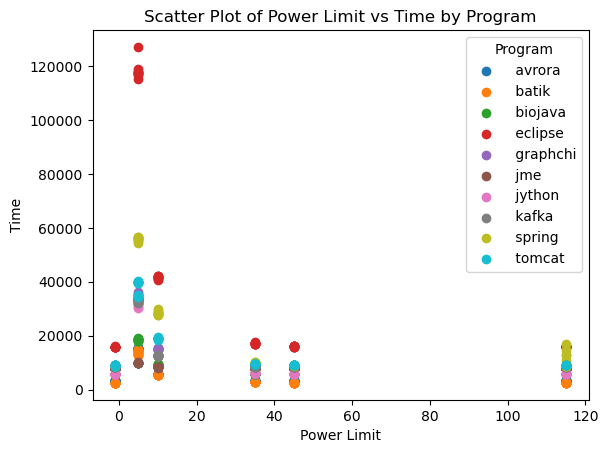

In [6]:
# Create scatter plots for each group
groups = df.groupby('Program')


for name, group in groups:
    plt.scatter(group['PowerLimit'], group['Time'], label=name)

plt.xlabel('Power Limit')
plt.ylabel('Time')
plt.title('Scatter Plot of Power Limit vs Time by Program')
plt.legend(title='Program')
plt.show()


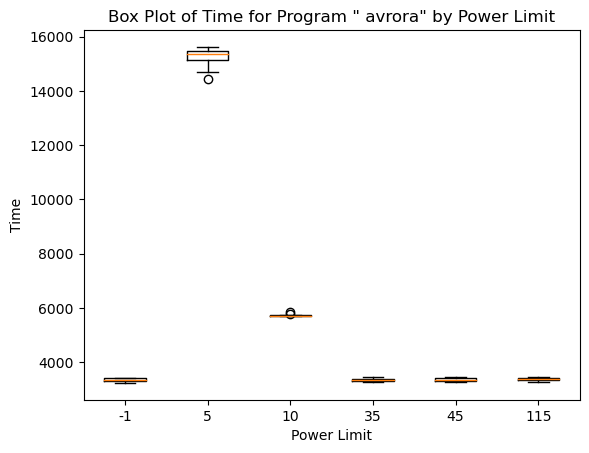

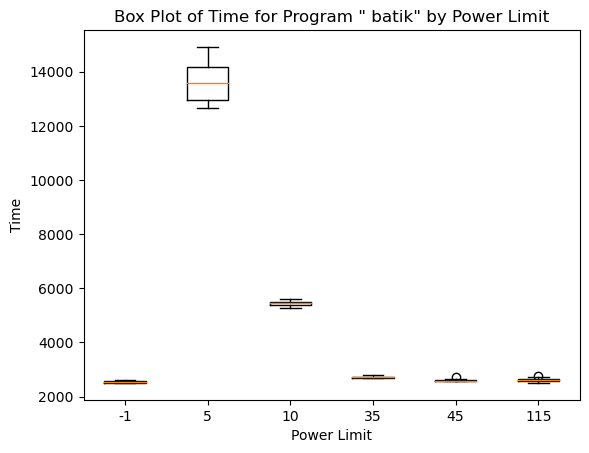

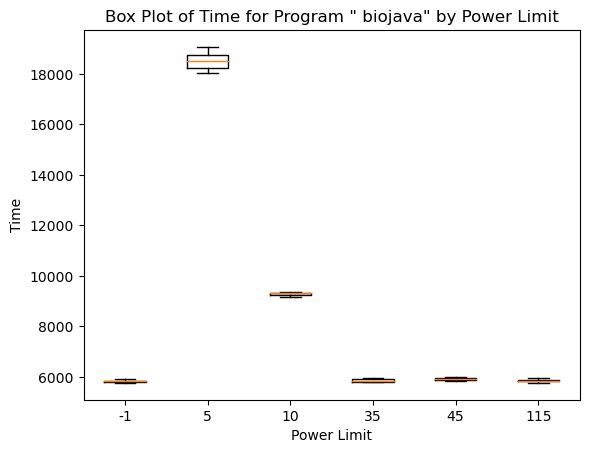

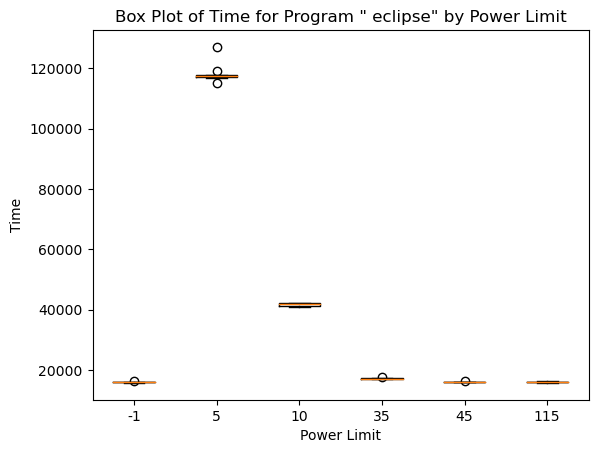

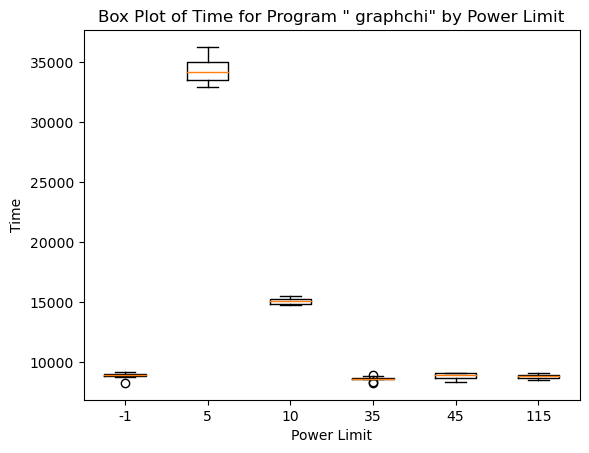

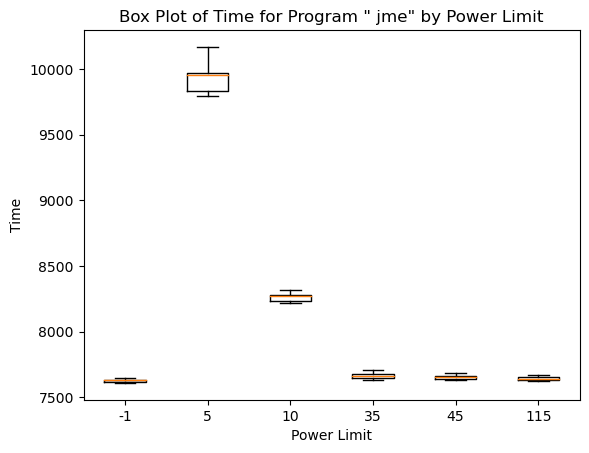

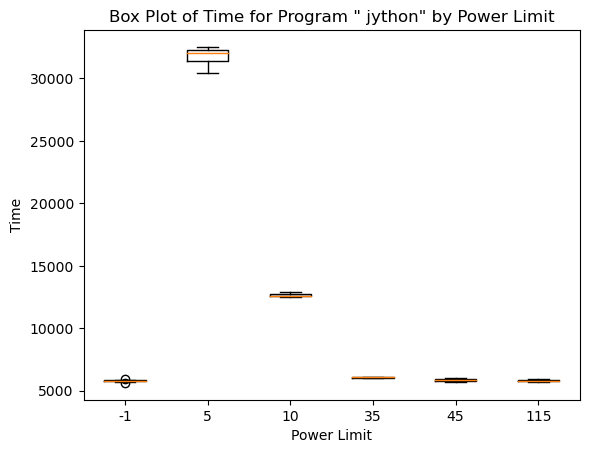

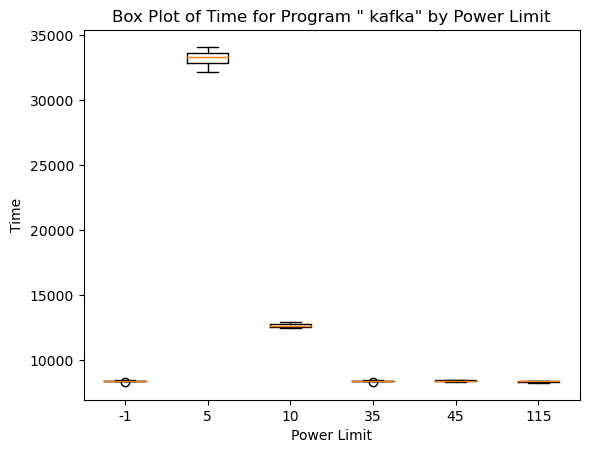

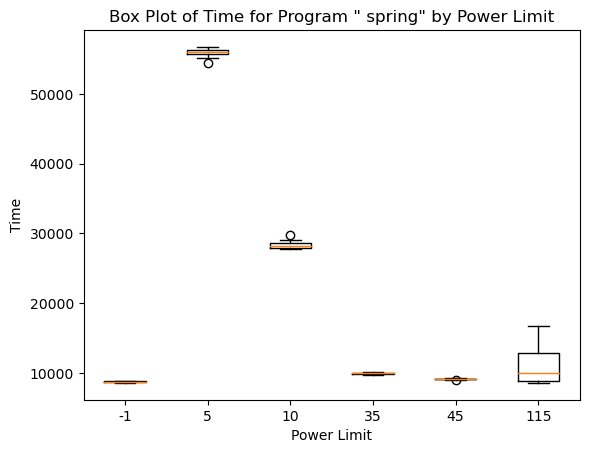

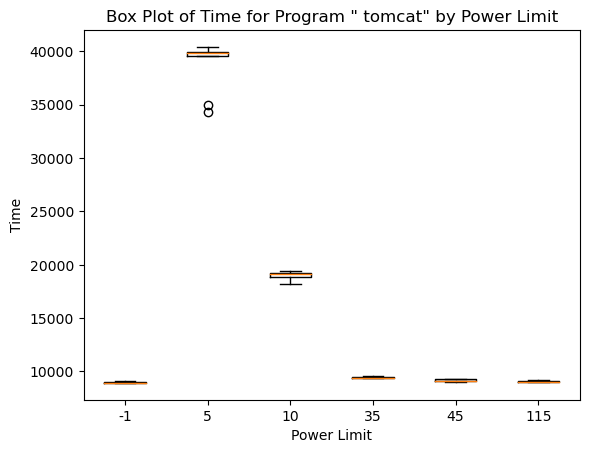

In [7]:

# Iterate over each program group

def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Time'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Time')
        plt.title(f'Box Plot of Time for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [8]:
## REMOVE OUTLIERS in each group (grouped by program and power limit)

grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
cleaned_df2 = cleaned_df.groupby(['Program'])
print(cleaned_df.count())


Program       576
PowerLimit    576
Time          576
dtype: int64


           PowerLimit  Time
Program                    
 avrora            60    60
 batik             60    60
 biojava           60    60
 eclipse           60    60
 graphchi          60    60
 jme               60    60
 jython            60    60
 kafka             60    60
 spring            60    60
 tomcat            60    60
Program       576
PowerLimit    576
Time          576
dtype: int64
           PowerLimit  Time
Program                    
 avrora            57    57
 batik             58    58
 biojava           60    60
 eclipse           54    54
 graphchi          56    56
 jme               60    60
 jython            58    58
 kafka             58    58
 spring            57    57
 tomcat            58    58


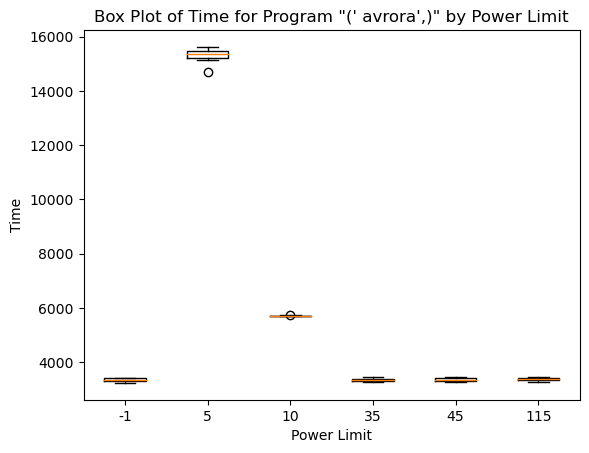

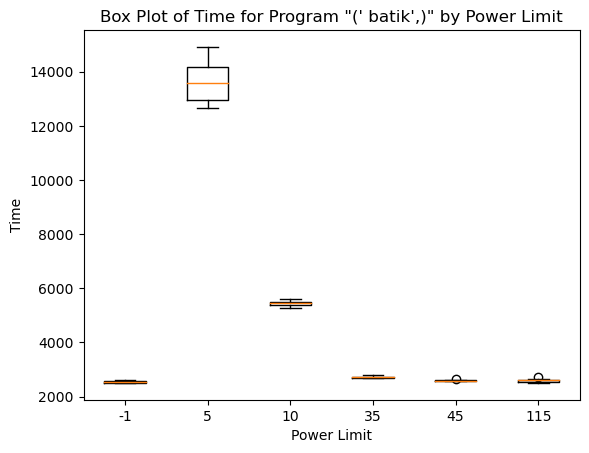

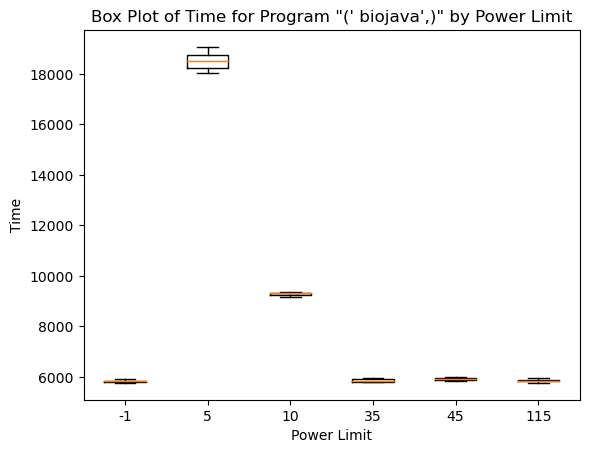

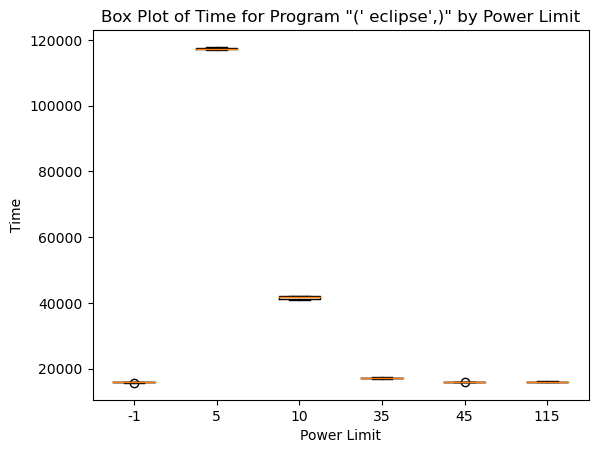

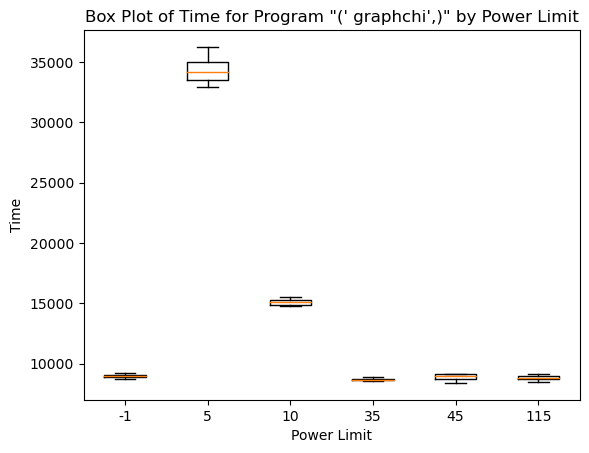

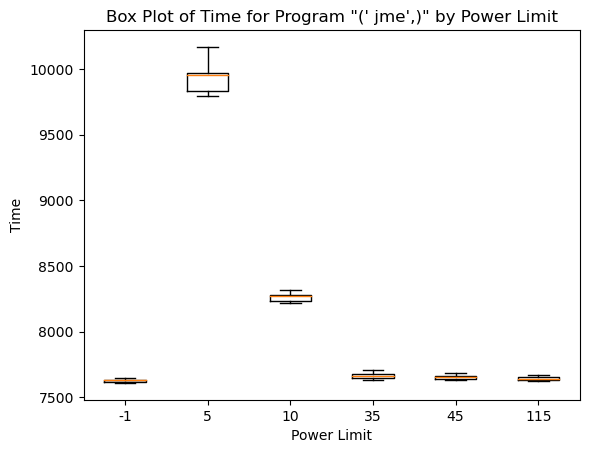

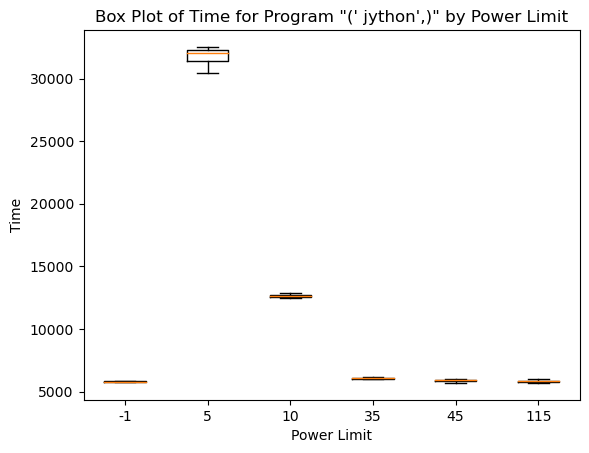

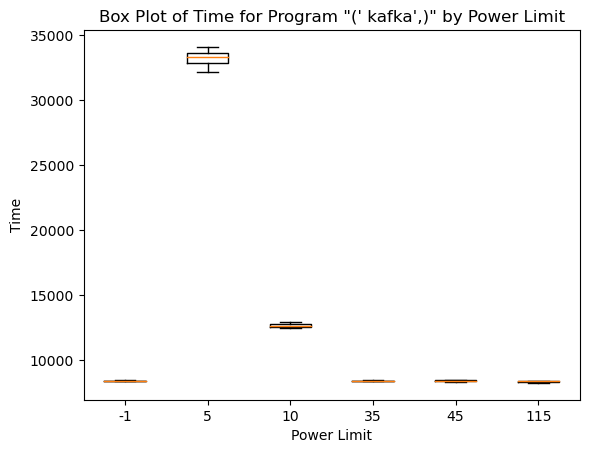

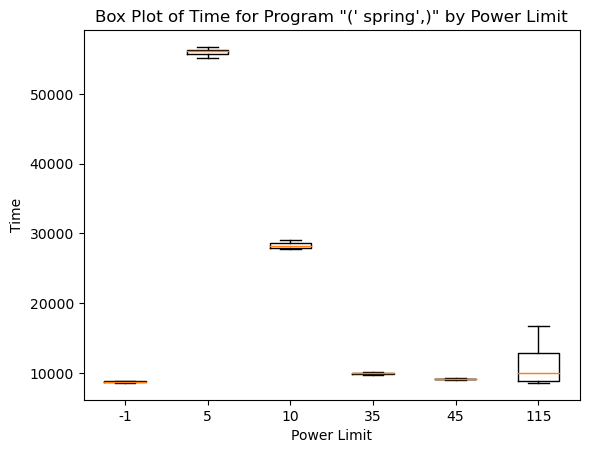

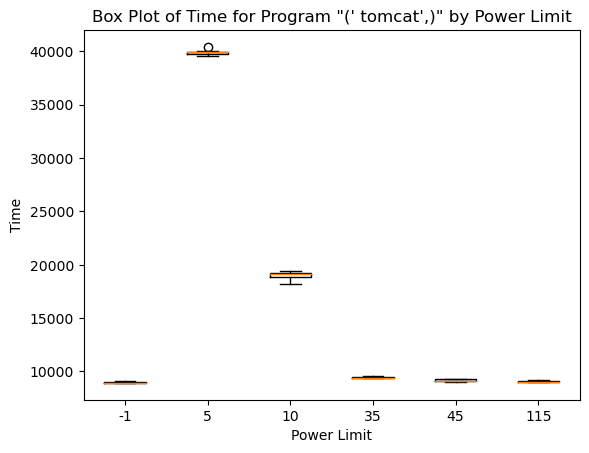

In [9]:
print(groups.count())
print(cleaned_df.count())
print(cleaned_df2.count())

show_box_plot(cleaned_df2)

In [10]:
def calculate_correlations(group):
    # Pearson correlation
    pearson_corr, pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # Kendall Tau correlation
    kendall_corr, kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [pearson_corr],
        'Pearson_p': [pearson_p],
        'Spearman': [spearman_corr],
        'Spearman_p': [spearman_p],
        'Kendall': [kendall_corr],
        'Kendall_p': [kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

     Program   Pearson  Pearson_p  Spearman    Spearman_p   Kendall  \
0     avrora -0.564877   0.000035 -0.691598  7.333472e-08 -0.535088   
1      batik -0.593656   0.000009 -0.929775  1.362748e-21 -0.813336   
2    biojava -0.598448   0.000004 -0.785991  1.361058e-11 -0.633877   
3    eclipse -0.571033   0.000042 -0.939537  1.247490e-21 -0.833493   
4   graphchi -0.601259   0.000008 -0.759291  6.160737e-10 -0.598768   
5        jme -0.599461   0.000004 -0.863477  7.122610e-16 -0.734245   
6     jython -0.597351   0.000005 -0.947652  1.919851e-25 -0.843876   
7      kafka -0.559774   0.000029 -0.838503  5.535895e-14 -0.700815   
8     spring -0.611959   0.000005 -0.816168  2.735913e-12 -0.707269   
9     tomcat -0.605464   0.000005 -0.957438  1.830671e-26 -0.863842   

      Kendall_p  
0  9.671018e-07  
1  4.828734e-14  
2  2.013618e-09  
3  8.614463e-14  
4  4.193553e-08  
5  3.967861e-12  
6  1.355685e-15  
7  5.400638e-11  
8  9.065535e-11  
9  1.222109e-15  


### Correlation Analysis between `PowerLimit` &&  `Time`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was apllied.

Here's the interpretation for each program in the provided output:

### Program: avrora

1. **Pearson**: -0.564877, p-value = 0.000035
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.691598, p-value = 7.333472e-08
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.535088, p-value = 9.671018e-07
   - Moderate negative association, statistically significant.

### Program: batik

1. **Pearson**: -0.593656, p-value = 0.000009
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.929775, p-value = 1.362748e-21
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.813336, p-value = 4.828734e-14
   - Strong negative association, statistically significant.

### Program: biojava

1. **Pearson**: -0.598448, p-value = 0.000004
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.785991, p-value = 1.361058e-11
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.633877, p-value = 2.013618e-09
   - Moderate negative association, statistically significant.

### Program: eclipse

1. **Pearson**: -0.571033, p-value = 0.000042
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.939537, p-value = 1.247490e-21
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.833493, p-value = 8.614463e-14
   - Strong negative association, statistically significant.

### Program: graphchi

1. **Pearson**: -0.601259, p-value = 0.000008
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.759291, p-value = 6.160737e-10
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.598768, p-value = 4.193553e-08
   - Moderate negative association, statistically significant.

### Program: jme

1. **Pearson**: -0.599461, p-value = 0.000004
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.863477, p-value = 7.122610e-16
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.734245, p-value = 3.967861e-12
   - Strong negative association, statistically significant.

### Program: jython

1. **Pearson**: -0.597351, p-value = 0.000005
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.947652, p-value = 1.919851e-25
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.843876, p-value = 1.355685e-15
   - Strong negative association, statistically significant.

### Program: kafka

1. **Pearson**: -0.559774, p-value = 0.000029
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.838503, p-value = 5.535895e-14
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.700815, p-value = 5.400638e-11
   - Strong negative association, statistically significant.

### Program: spring

1. **Pearson**: -0.611959, p-value = 0.000005
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.816168, p-value = 2.735913e-12
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.707269, p-value = 9.065535e-11
   - Strong negative association, statistically significant.

### Program: tomcat

1. **Pearson**: -0.605464, p-value = 0.000005
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.957438, p-value = 1.830671e-26
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.863842, p-value = 1.222109e-15
   - Strong negative association, statistically significant.

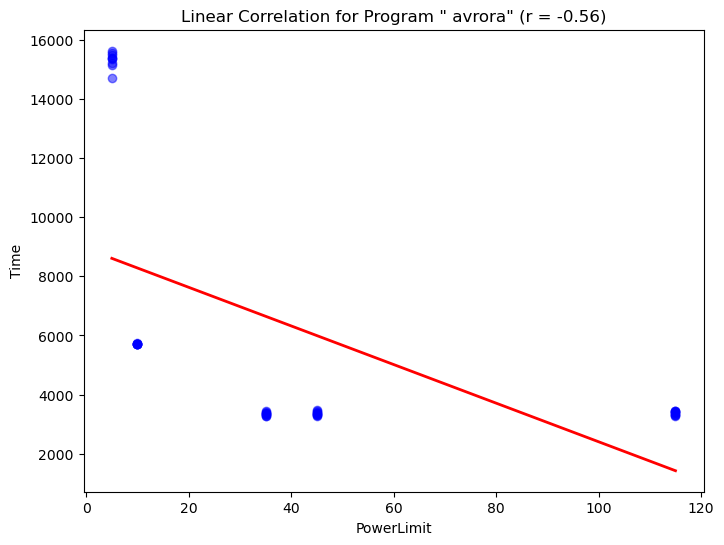

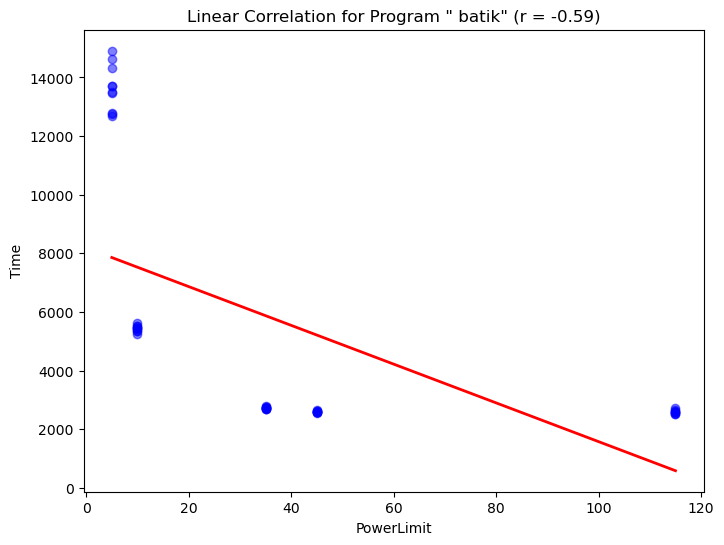

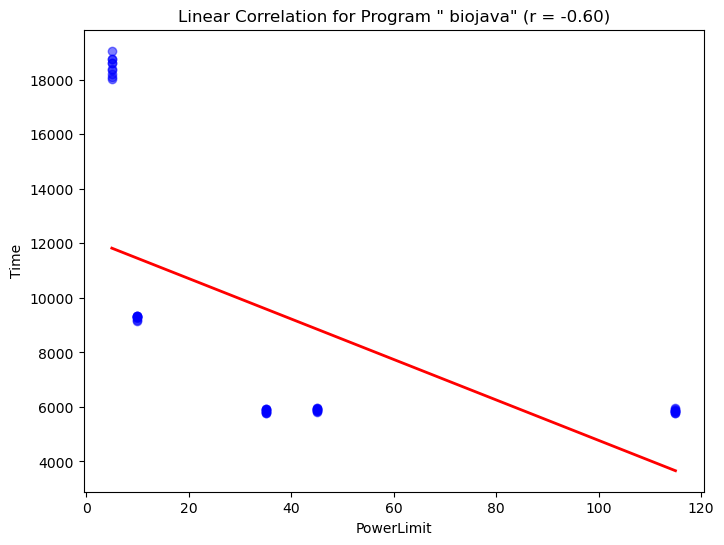

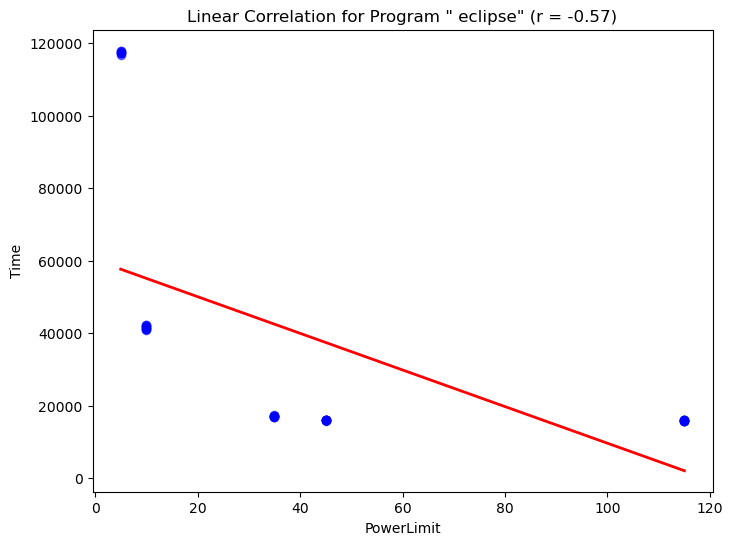

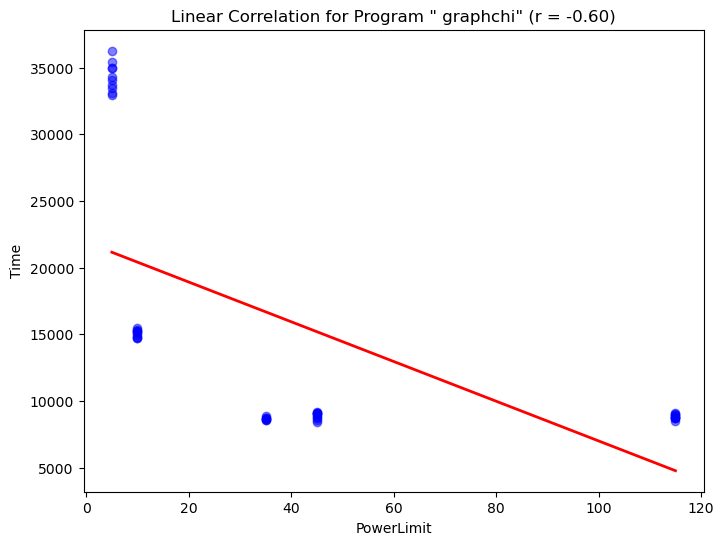

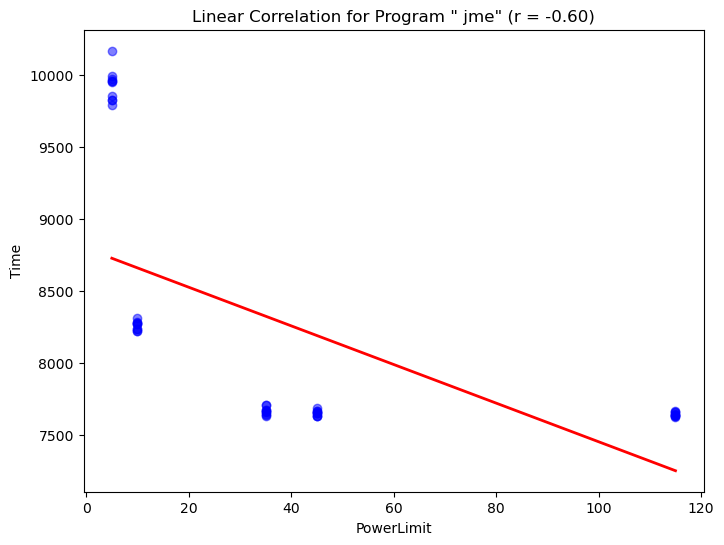

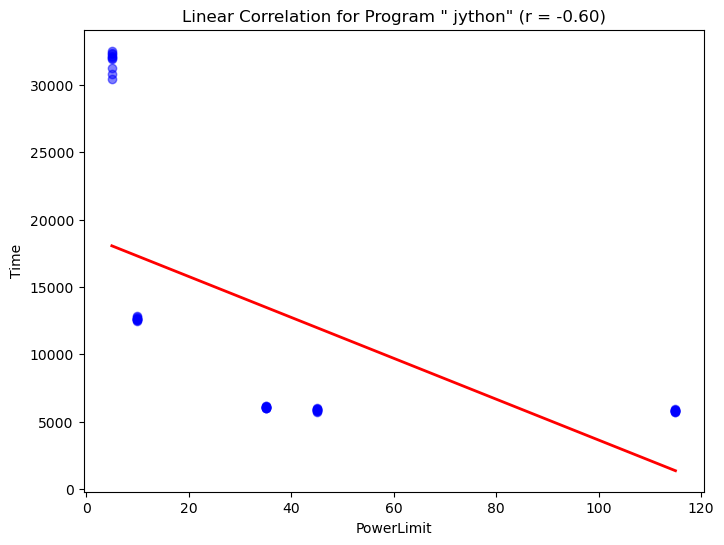

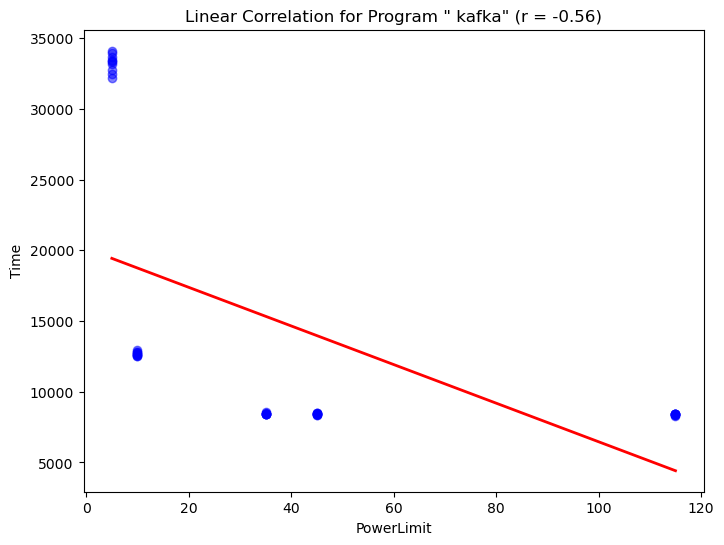

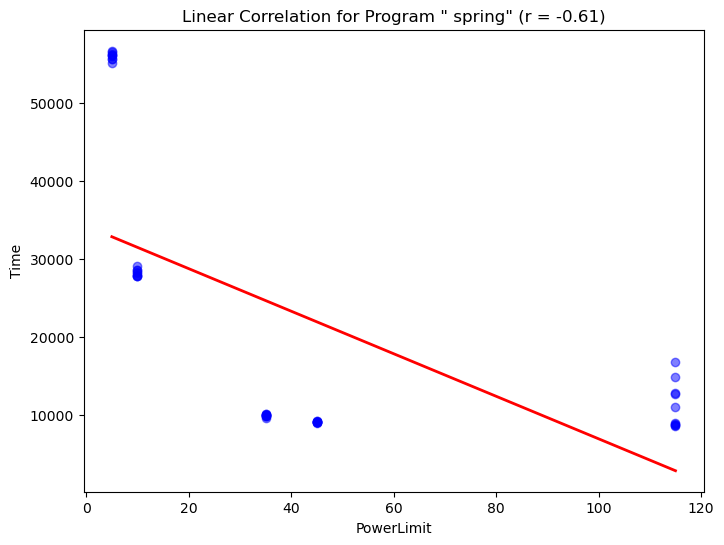

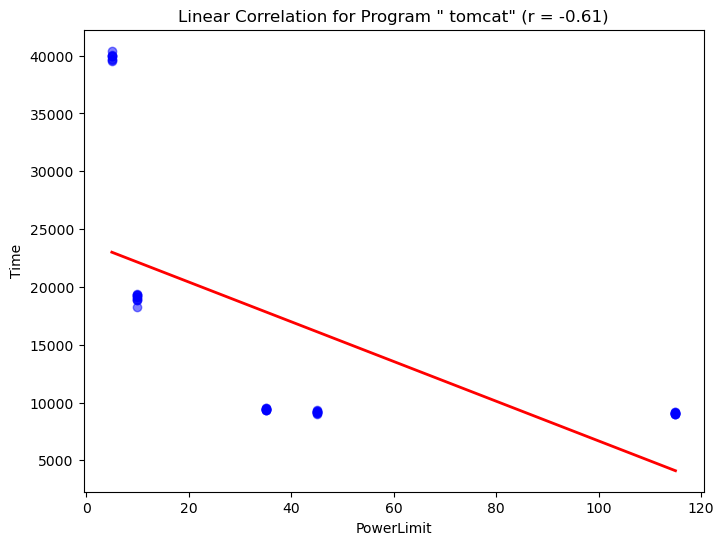

In [11]:
def show_correlation_plot(groups):
    for name, program_group in groups:
        # Calculate correlation for the current program group
        pearson_corr, pearson_p = stats.pearsonr(program_group['Time'], program_group['PowerLimit'])

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Time'], color='blue', alpha=0.5)

        # Add the linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Time'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Time')
        plt.title('Linear Correlation for Program "{}" (r = {:.2f})'.format(name, pearson_corr))
        plt.show()

# Assuming 'groups' is already defined elsewhere
show_correlation_plot(cleaned_df3.groupby('Program'))

## Conclusion

Overall, the correlation analysis reveals consistent negative relationships between `Time` and `PowerLimit` across various programs. 

This proves the initial hypothesis that Powercap caps the performance of the CPU which makes us conclude that the lower the value in the Powerlimit the higher the power limitation.